In [57]:
#pip install yfinance numpy pandas scikit-learn matplotlib lightgbm
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor

In [58]:
# ===================== 1. Tải dữ liệu cổ phiếu & lưu vào CSV ===================== #
stocks_info = {
    "AAPL": {"ticker": "AAPL", "start": "2013-07-10", "end": "2025-01-16"},
    "AMZN": {"ticker": "AMZN", "start": "2013-07-10", "end": "2025-01-16"},
    "GOOGL": {"ticker": "GOOGL", "start": "2013-07-10", "end": "2025-01-16"},
    # "VNM": {"ticker": "VNM.HM", "start": "2023-07-18", "end": "2025-01-16"}
}

In [59]:
# Tải dữ liệu từ Yahoo Finance và lưu vào file CSV
for stock, info in stocks_info.items():
    df = yf.download(info["ticker"], start=info["start"], end=info["end"])
    df = df[["Close"]]
    df.columns = [stock]
    df.to_csv(f"{stock}.csv")
    print(f"Đã lưu dữ liệu {stock}.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Đã lưu dữ liệu AAPL.csv
Đã lưu dữ liệu AMZN.csv


[*********************100%***********************]  1 of 1 completed

Đã lưu dữ liệu GOOGL.csv


In [60]:
all_data = {}
for stock in stocks_info.keys():
    df = pd.read_csv(f"{stock}.csv", index_col=0, parse_dates=True)
    all_data[stock] = df

# Kiểm tra số cột từng DataFrame
for stock, df in all_data.items():
    print(f"{stock}: {df.shape}")  

# Lấy index chuẩn từ cổ phiếu đầu tiên
common_index = all_data[next(iter(all_data))].index  
all_data = {stock: df.reindex(common_index) for stock, df in all_data.items()}  

# **Di chuyển phần này lên trước khi in `data.shape[1]`**
# Gộp dữ liệu vào một DataFrame
data = pd.concat(all_data.values(), axis=1)
data.columns = stocks_info.keys()
data.dropna(inplace=True)  # Xóa giá trị NaN nếu có

# Kiểm tra lại số cột sau khi xử lý
print(f"Số cột thực tế trong data: {data.shape[1]}")
print(f"Số mã cổ phiếu trong stocks_info: {len(stocks_info)}")

AAPL: (2899, 1)
AMZN: (2899, 1)
GOOGL: (2899, 1)
Số cột thực tế trong data: 3
Số mã cổ phiếu trong stocks_info: 3


In [61]:
# ===================== 3. Tiền xử lý dữ liệu ===================== #
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Chia tập train/test (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled.iloc[:train_size], data_scaled.iloc[train_size:]

In [62]:
# ===================== 4. Huấn luyện mô hình DLinear ===================== #
class DLinear:
    def __init__(self, forecast_horizon):
        self.model = LGBMRegressor()
        self.forecast_horizon = forecast_horizon
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

In [63]:
# Dự báo cho từng cổ phiếu
dlinear_predictions = {}
actual_values = {}


In [64]:
for stock in stocks_info.keys():
    print(f"Huấn luyện DLinear cho {stock}...")

    # Chuẩn bị dữ liệu riêng cho từng cổ phiếu
    X_train, y_train = train_data.drop(columns=[stock]), train_data[stock]
    X_test, y_test = test_data.drop(columns=[stock]), test_data[stock] 

    # Khởi tạo mô hình mới cho từng cổ phiếu
    model = DLinear(forecast_horizon=10)  
    model.fit(X_train, y_train)

    # Dự báo & lưu kết quả
    y_pred = model.predict(X_test)
    dlinear_predictions[stock] = y_pred
    actual_values[stock] = y_test  # Lưu giá trị thực tế để đánh giá

Huấn luyện DLinear cho AAPL...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2319, number of used features: 2
[LightGBM] [Info] Start training from score 0.192095
Huấn luyện DLinear cho AMZN...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2319, number of used features: 2
[LightGBM] [Info] Start training from score 0.284787
Huấn luyện DLinear cho GOOGL...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data 

In [65]:
# ===================== 5. Đánh giá mô hình ===================== #
metrics = {}
for stock in stocks_info.keys():
    y_true = actual_values[stock]
    y_pred = dlinear_predictions[stock]
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics[stock] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape, "R²": r2}

In [66]:
# In ma trận đánh giá
metrics_df = pd.DataFrame(metrics).T
print("\nMa trận đánh giá mô hình DLinear:")
print(metrics_df)


Ma trận đánh giá mô hình DLinear:
            MSE      RMSE       MAE      MAPE        R²
AAPL   0.030904  0.175795  0.148279  0.202586 -0.913811
AMZN   0.019406  0.139304  0.112332  0.226946  0.399417
GOOGL  0.012728  0.112819  0.092048  0.139552  0.576783


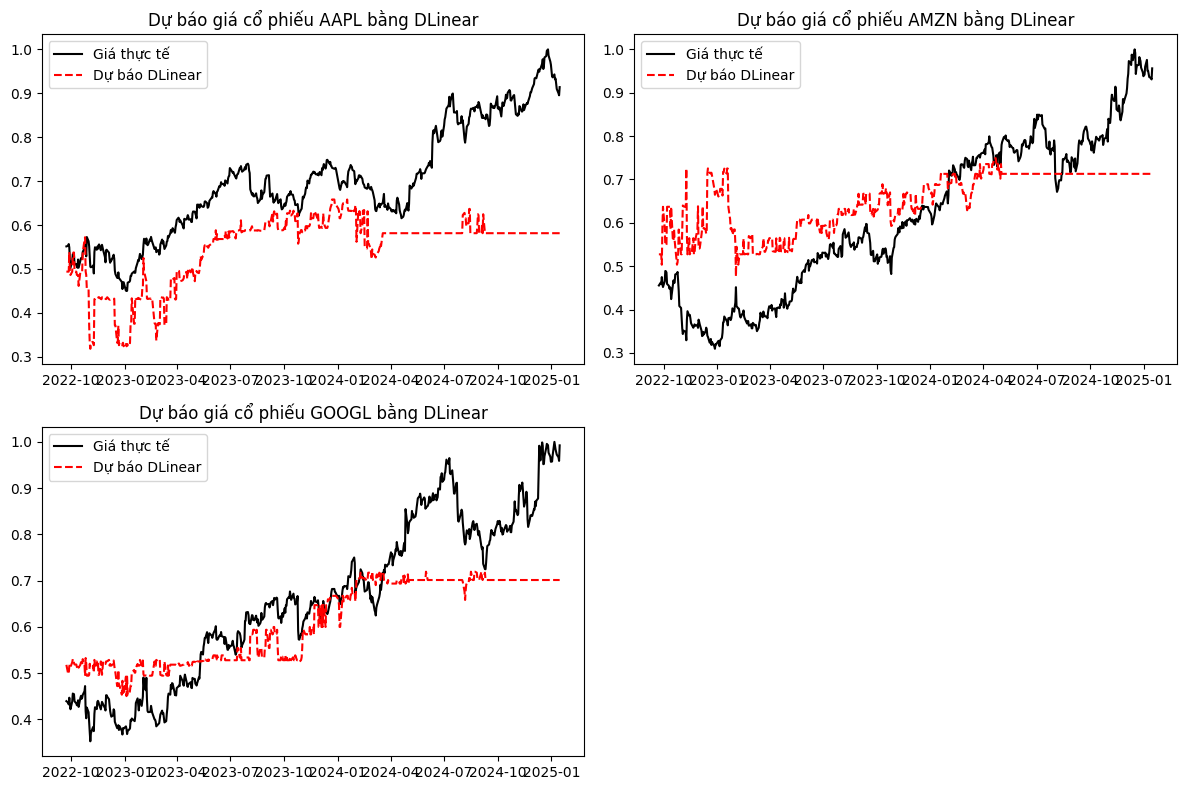

In [67]:
# ===================== 6. Vẽ đồ thị so sánh ===================== #
plt.figure(figsize=(12, 8))

for i, stock in enumerate(stocks_info.keys(), 1):
    plt.subplot(2, 2, i)
    plt.plot(test_data.index, actual_values[stock], label="Giá thực tế", color="black")
    plt.plot(test_data.index, dlinear_predictions[stock], label="Dự báo DLinear", linestyle="dashed", color="red")
    plt.title(f"Dự báo giá cổ phiếu {stock} bằng DLinear")
    plt.legend()

plt.tight_layout()
plt.show()